<a href="https://colab.research.google.com/github/Taedriel/ZSL-v2/blob/googleImageFSL/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!yes | pip install -U --quiet selenium scikit-learn-intelex Pillow sklearn
!cd "./drive/MyDrive/Colab Notebooks/pipeline" && pip install -r --quiet requirements.txt

!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, itertools, shutil, requests, webbrowser, urllib.request, time, random
import PIL.Image

from IPython.core.display import Image
from statistics import mean, pstdev
from selenium import webdriver
from bs4 import BeautifulSoup 

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms, utils
from torchvision.models import resnet18, resnet50
from sklearn.metrics import classification_report, confusion_matrix

from tqdm import tqdm

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
PATH = "/content/drive/MyDrive/Colab Notebooks/pipeline/"
PATH_IMAGES = "/content/drive/MyDrive/Colab Notebooks/pipeline/images/"
PATH_DATA = "/content/drive/MyDrive/Colab Notebooks/pipeline/model/dataO/omniglot-py/images_background/" #"/content/drive/MyDrive/Colab Notebooks/pipeline/model/data/CUB/images/"
PATH_MODEL = "/content/drive/MyDrive/Colab Notebooks/pipeline/model/"

globalSize = 20
LEN_FOR_ONE_SCROLL = 20

N_WAY = 5
N_SHOT = 5
N_QUERY = 15

batchSize = 1000

--- UTILS ---

In [5]:
def createListOfClasses(classesFile):

  """
  get set of all classes to be used in the support set from Ismael's text file
  """

  classes = []
  index=0

  for animal in classesFile.readlines():
    animal = animal.strip("\n").replace(" ", "")
    classes.append(animal)

  return classes

In [6]:
def getUa(mesurements, k=1):

  """
  get mean and incertitude from a list of mesurements, the first element in the list
  must be the title of the experiement.
  """

  title = mesurements[0]
  l = mesurements[1:]
  inv_n = 1.0/(len(l)-1)
  inv_ns = 1.0/pow(len(l), 0.5)
  m_ = round(mean(l), 2)
  dm2 = [pow(mi - m_, 2) for mi in l]
  pstd = pow(inv_n*sum(dm2), 0.5)
  u = round(k*pstd*inv_ns, 2)
  
  return title+str(m_) + "% +- " + str(u) + " (with 95% confidence)" if k!=1 else "", m_, u

def getUaList(listOfExperiences, k=1):

  for mesurements in listOfExperiences:
    string, m_, u = getUa(mesurements, k)
    print(string)

In [7]:
def getOnlyImages(set_):
  justSet = []
  for class_ in set_:
    for image in class_:
      justSet.append(image[0])

  return torch.stack(justSet)

def plot_images(images, title, images_per_row):
  plt.figure()
  plt.title(title)
  plt.imshow(utils.make_grid(images, nrow=images_per_row).permute(1, 2, 0))

In [8]:
def saveFile(filename, data):
  file = open(PATH_MODEL+filename, "w+")
  for d in data:
    file.write(str(d)+"\n")
  file.close()

def showRegression(rangeOfData, data, degree):
  coef = np.polyfit(rangeOfData, data, degree)
  poly1d_fn = np.poly1d(coef) 
  plt.plot(rangeOfData, data, '-yo', rangeOfData, poly1d_fn(rangeOfData), '--k')
  plt.show()
  print("regression polynome :\n")
  print(np.poly1d(poly1d_fn))
  print("started at", data[0], "and ended at", data[-1])
  print("\n")

def showData(data, title, degree, saveInfo=[False, ""]):

  path = saveInfo[1]
  if saveInfo[0]:
    saveFile(path, data)

  numberOfIteration = range(0, len(data))

  plt.plot(numberOfIteration, data)
  plt.title(title)
  plt.show()
  showRegression(numberOfIteration, data, degree)

In [9]:
def getMatrixReport(labels, predicted_labels):
    print("\n")
    listOfClasses = list(dict.fromkeys(labels))
    res = classification_report(labels, predicted_labels, target_names=["c"+str(i) for i in range(1, len(listOfClasses)+1)],  output_dict=True)
    return res, res['accuracy'], confusion_matrix(labels, predicted_labels)

--- IMAGE RETRIEVAL ---

In [10]:
"""
thumbnail / jpg (compression) may be an issue
"""

def getParser(classeName):

  site = 'https://www.google.com/search?tbm=isch&q='+classeName

  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')

  driver = webdriver.Chrome('chromedriver', options=chrome_options)
  driver.get(site)
  driver.execute_script("window.scrollBy(0, document.body.scrollHeight)")
  soup = BeautifulSoup(driver.page_source, 'html.parser')
  driver.close()

  return soup


def getImages(classes):

  imagesNumber = 0

  shutil.rmtree(PATH_IMAGES, ignore_errors=False)
  os.makedirs(PATH_IMAGES)

  print("downloading images...")

  for classe in tqdm(classes.split(",")):

    try:
      classeName = classe.replace(" ", "")
      os.makedirs(PATH_IMAGES+classeName)

      soup = getParser(classeName)
      img_tags = soup.find_all("img", class_="rg_i")

      for index in range(0, len(img_tags)):
        try:
            urllib.request.urlretrieve(img_tags[index]['src'], PATH_IMAGES+classeName+"/"+str(classeName+str(index))+".jpg")
            imagesNumber+=1
        except Exception as e:
            pass
    except:
      pass

  return imagesNumber

def getClassesImagesURLLIB(classes, download=True):

  imagesNumber = 0

  if download:
    imagesNumber = getImages(classes)
  
  print("\n"+str(imagesNumber) + " images were downloaded. " + str(imagesNumber/len(classes.split(","))) + " per classes")

In [ ]:
retreivalNotDone = False

classesFile = open(PATH_MODEL+"animals.txt")
classes = createListOfClasses(classesFile)
print("classes :", classes)

if retreivalNotDone:
  getClassesImagesURLLIB(classes, retreivalNotDone)
  retreivalNotDone = False

classes : ['Aardvark', 'Aardwolf', 'Africanbuffalo', 'Africanelephant', 'Africanleopard', 'Albatross', 'Alligator', 'Alpaca', 'Americanrobin', 'Amphibian', 'Anaconda', 'Angelfish', 'Anglerfish', 'Ant', 'Anteater', 'Antelope', 'Antlion', 'Ape', 'Aphid']


--- DATASET ---

In [11]:
def getNrandomClassesPaths(listClasses, n_way):

  paths = []
  for i in range(0, n_way):
    ridx = random.randint(0, len(listClasses)-1)
    paths.append(PATH_DATA+listClasses[ridx]+"/")
    listClasses.remove(listClasses[ridx])

  return paths

In [12]:
imageResize = (224, 224)

# each set is as follows : 
"""
[
  [(I, c), (I, c), ..., (I, c), (I, c)],
  [(I, c), (I, c), ..., (I, c), (I, c)],
   .          .                    .
   .            .                  .
   .              .                .
   .                .              .
                      .            .
  [(I, c), (I, c), ..., (I, c), (I, c)]
]
"""

def getImageTensor(path):
  convert = transforms.Compose([
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor(),
                                transforms.Normalize((0, 0, 0), (1, 1, 1))
                              ])
  return convert(PIL.Image.open(path).resize(imageResize))

def getFolderTensors(path, supportNumber, queryNumber, label):

  images = os.listdir(path)
  support_i, query_i = [], []

  for i in range(0, supportNumber):
    ridx = random.randint(0, len(images)-1)
    support_i.append( (getImageTensor(path+images[ridx]), label) )
    images.remove(images[ridx])
  
  for i in range(0, queryNumber):
    ridx = random.randint(0, len(images)-1)
    query_i.append( (getImageTensor(path+images[ridx]), label) )
    images.remove(images[ridx])

  return support_i, query_i

def getSets(paths, supportNumber, queryNumber):

  supportSet, querySet = [], []
  for label, path in enumerate(paths):
    Si, Qi = getFolderTensors(path, supportNumber, queryNumber, label)
    supportSet.append(Si)
    querySet.append(Qi)

  return supportSet, querySet

In [13]:
def getPair(c1, i, c2, j, setOfImages):

  I1 = setOfImages[c1][i][0]
  I2 = setOfImages[c2][j][0]
  s = 1.0 if c1 == c2 else 0.0

  return I1, I2, s

"""
For both PP and NP
compute cartesian product of set (without doublons).
For PP the sets are horizontal (images of same class)
For NP the sets are vertical (iamges of different class)

possible bias because (theorically) PP = NP ?
"""

"""
[
  [(I, c), (I, c), ..., (I, c), (I, c)],
  [(I, c), (I, c), ..., (I, c), (I, c)],
   .          .                    .
   .            .                  .
   .              .                .
   .                .              .
                      .            .
  [(I, c), (I, c), ..., (I, c), (I, c)]
]
"""

def getPP(setOfImages):

  PP = []
  for set_ in range(0, N_WAY):
    for offset in range(0, N_SHOT):
      for other in range(offset, N_SHOT):
        PP.append(getPair(set_, offset, set_, other, setOfImages))

  return PP

def getNP(setOfImages):

  NP = []
  for set_ in range(0, N_SHOT):
    for offset in range(0, N_WAY):
      for other in range(offset+1, N_WAY):
        NP.append(getPair(offset, set_, other, set_, setOfImages))

  return NP


def generatePNPairs(setOfImages):

  PP, NP = [], []
  PP = getPP(setOfImages)
  NP = getNP(setOfImages)

  SET = PP + NP
  random.shuffle(SET)
  return SET

  # ------------------------

def getRandomPair(setOfImages):
  nbClasses = len(setOfImages)
  nbEx = len(setOfImages[0])
  ci1, e1 = random.randint(0, nbClasses-1), random.randint(0, nbEx-1) 
  ci2, e2 = random.randint(0, nbClasses-1), random.randint(0, nbEx-1)

  I1 = torch.stack([setOfImages[ci1][e1][0]])
  I2 = torch.stack([setOfImages[ci2][e2][0]])

  return I1, I2, 1.0 if ci1 == ci2 else 0.0

--- NETWORK ---

In [14]:
# taken from https://github.com/fangpin/siamese-pytorch/blob/master/model.py and modified

"""
I1 --> CNN --> u
                \
                  |u-v| --> NN --> x --> s(x) --> L(.,.)
                /
I2 --> CNN --> v
"""

cuda_ = True

backbone = resnet50(pretrained=True)
modules=list(backbone.children())[:-1]
combination = lambda u, v: torch.abs(u-v)               

def get_vector(image):

  image = image.cuda() if cuda_ else image
  return torch.flatten(backbone(image))

def createCombinedVector(I1, I2):

  u = get_vector(I1)
  v = get_vector(I2)
  return combination(u, v)

class Siamese(nn.Module):

  def __init__(self):
    super(Siamese, self).__init__()
    self.enter = 2048
    self.hidden = 1024
    
    self.metric = nn.Sequential(nn.Linear(self.enter, self.hidden), nn.ReLU(),
                                
                                nn.Linear(self.hidden, self.hidden), nn.ReLU(),
                                nn.Linear(self.hidden, self.hidden), nn.ReLU(),

                                nn.Linear(self.hidden, 1)) 

  def forward(self, w):
    out = self.metric(w)
    out_normalized = torch.sigmoid(out)

    return out_normalized


if cuda_:
  backbone=nn.Sequential(*modules).cuda() 
  model = Siamese().cuda()
else:
  backbone=nn.Sequential(*modules)
  model = Siamese()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
reset = True

if reset:
  for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
      layer.reset_parameters()

In [15]:
ADAM = True

if ADAM:
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
else:
  torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.5)

--- TESTING FUNCTIONS ---

In [16]:
def getImages(image1, image2):

  if image1.dim() < 4:
    image1 = image1.unsqueeze(0)
  
  if image2.dim() < 4:
    image2 = image2.unsqueeze(0)

  return image1, image2

In [17]:
def getFirstClassBasedOnRepresentation(predictions):

  representation = [0]*N_WAY
  for pred in predictions:
    representation[pred[0]] += 1

  return representation.index(max(representation))

def isCorrect(predictions, queryClass):

  pred_sorted = sorted(predictions, key=lambda tup: tup[-1], reverse=True)
  first_five = pred_sorted[0:5]

  predictedClassLabel = getFirstClassBasedOnRepresentation(first_five)
  similarity = int(queryClass == predictedClassLabel)
  
  #print("query is ", queryClass, " and prediction are :", list(map(lambda t: (t[0], t[1].cpu().numpy()[0]), pred_sorted[0:5])), " similarity : ", int(queryClass == pred_sorted[0][0]))
  print("query is", queryClass, "and prediction is", predictedClassLabel, "similarity : ", similarity)

  return similarity, predictedClassLabel

def evaluate(supportSet, querySet):

  triplets = []
  pred_labels = []
  query_labels = []
  correctClass, correct = 0, 0
  
  model.eval()
  with torch.no_grad():

    for indexQuery, queryInfo in enumerate(list(itertools.chain(*querySet))):

      torch.cuda.empty_cache()
      query, queryClass = queryInfo

      for imageInfo in list(itertools.chain(*supportSet)):

        image, imageClass = imageInfo
        query, image = getImages(query, image)
        w = createCombinedVector(query, image)
        p = model(w)
        triplets.append((imageClass, p))
      
      areReallySimilar, imageClass = isCorrect(triplets, queryClass)
      if areReallySimilar == 1: correct+=1
      triplets = []
      pred_labels.append(imageClass)
      query_labels.append(queryClass)

  return "\n accuracy :"+str(100.0*correct/(N_WAY*N_QUERY)), pred_labels, query_labels

--- TRAINING FUNCTIONS ---

In [18]:
LOSS = nn.BCELoss() # nn.MSELoss() # 

In [23]:
def saveModel(epoch, loss_value):

  torch.save({
  'epoch': epoch,
  'model_state_dict': model.state_dict(),
  'optimizer_state_dict': optimizer.state_dict(),
  'loss': loss_value
  }, "/content/drive/MyDrive/Colab Notebooks/pipeline/model/model_check_start.pt")

In [21]:
def epoch(suppSet):

  lossForBatch = []
  for i in range(0, batchSize):

    I1, I2, s = getRandomPair(suppSet)

    # talk to feeham :
    """
    where does your training start ? => NN.
    but start with w creation. Does it influence ?
    """

    I1, I2 = getImages(I1, I2)
    w = createCombinedVector(I1, I2)
    out = model(w)
    s = torch.tensor([s]).cuda() if cuda_ else torch.tensor([s])

    optimizer.zero_grad()
    loss = LOSS(out, s)
    loss.backward()
    optimizer.step()
    lossForBatch.append(loss.item())

  return lossForBatch


validation = False
def training(supportSet, querySet):

  numberOfEpochs = 200
  setOfPairs = generatePNPairs(supportSet)

  valFreq = 10
  bestAcc = 0.0
  bestModel = model.state_dict()

  losses = []
  
  model.train()
  for epoch_i in tqdm(range(0, numberOfEpochs)):

    batchLoss = epoch(supportSet)
    mean_loss = sum(batchLoss)*1.0/len(batchLoss)
    losses.append(mean_loss)

    if epoch_i % valFreq == 0 and epoch_i != 0:
      saveModel(model, mean_loss)

  torch.save(model.state_dict(), PATH_MODEL+"SN.pt")

  return losses

--- ACTUAL MODEL PIPELINE ---

In [26]:
CUB, OMNIGLOT = False, True

if CUB:
  listClass = os.listdir(PATH_DATA)
elif OMNIGLOT:
  listAlphabet = os.listdir(PATH_DATA)
  choosenAlphabet = listAlphabet[random.randint(0, len(listAlphabet)-1)]
  listClass = [choosenAlphabet+"/"+char for char in os.listdir(PATH_DATA+choosenAlphabet)]

In [27]:
print(listClass)

['Hebrew/character01', 'Hebrew/character02', 'Hebrew/character03', 'Hebrew/character04', 'Hebrew/character05', 'Hebrew/character06', 'Hebrew/character07', 'Hebrew/character08', 'Hebrew/character09', 'Hebrew/character10', 'Hebrew/character11', 'Hebrew/character12', 'Hebrew/character13', 'Hebrew/character14', 'Hebrew/character15', 'Hebrew/character16', 'Hebrew/character17', 'Hebrew/character18', 'Hebrew/character19', 'Hebrew/character20', 'Hebrew/character21', 'Hebrew/character22']


In [28]:
supportClasses = getNrandomClassesPaths(listClass, N_WAY)
supportSet, querySet = getSets(supportClasses, N_SHOT, N_QUERY)

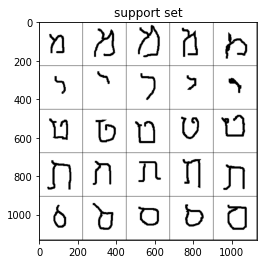

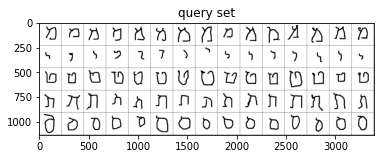

In [29]:
justSupport = getOnlyImages(supportSet)
justQuery = getOnlyImages(querySet)
plot_images(justSupport, title="support set", images_per_row=N_SHOT)
plot_images(justQuery, title="query set", images_per_row=N_QUERY)

In [25]:
save, load = False, False
if save : 
  torch.save(model.state_dict(), PATH_MODEL+"SN_startingPoint.pt")
  saveModel(0, 0)
if load : model.load_state_dict(torch.load(PATH_MODEL+"SN_startingPoint.pt"))

In [ ]:
trainingNeeded = True

if trainingNeeded:
  losses = training(supportSet, querySet)
else:
  model.load_state_dict(torch.load(PATH_MODEL+"SN.pt"))
  print("model loaded")

 62%|██████▎   | 125/200 [2:03:43<1:14:19, 59.45s/it]

In [ ]:
showData(losses, "loss during training", 3)

In [ ]:
accuracyResults, y_pred, y = evaluate(supportSet, querySet)

_, _, confM = getMatrixReport(y, y_pred)
print(accuracyResults)
print(confM)

In [4]:
listOfExperiences5 = [
                     ["(Adam, 1E-3), 3h1o (512, 240)..(240, 1)), Pre-done, 350x350, BCELoss, 70 epochs: ", 41, 40, 30.66, 34.66, 26.66],
                     ["(Adam, 1E-3), 3h1o (512, 240)..(240, 1)), Random  , 350x350, BCELoss, 70 epochs: ", 38.67, 26.67, 34.67, 38.67, 45],
                     ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 224x224, BCELoss, 70 epochs, normalized: ", 62.67, 50.67, 45.33, 54.67, 52],
                     ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 224x224, MSELoss, 70 epochs, normalized, representation, Omni ", 77.33, 77.33, 78.67, 77.33],
                     ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 224x224, MSELoss, 70 epochs, normalized, representation, Omni with reset ", 94.67, 86.67, 72]
                    ]
listOfExperiences6 = [
                      ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 224x224, BCELoss, 70 epochs, normalized, representation: ", 60, 53.33, 72, 46.67, 53.33, 42.67],
                      ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 224x224, BCELoss, 70 epochs, normalized, representation, Omni: ", 84, 74.67, 92, 77.33, 76, 68]
                      ]

listOfExperiences7 = [
                      ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 350x350, BCELoss, 70 epochs: ", 48, 46.67, 48, 41.33, 49, 42, 40]
                      ]

TotalList = [listOfExperiences5,
             listOfExperiences6, 
             listOfExperiences7
            ]

In [ ]:
getUaList(listOfExperiences5, 2.776)
getUaList(listOfExperiences6, 1.945)
getUaList(listOfExperiences7, 1.895)

In [ ]:
for listExp in TotalList:
  for x in listExp:
    plt.hist(x[1:])
    plt.title(x[0])
    plt.show()